# Weighted dCGP for a symbolic regression task 

In [1]:
from pyaudi import gdual_vdouble as gdual
from dcgpy import expression_weighted_gdual_vdouble as expression
from dcgpy import kernel_set_gdual_vdouble as kernel_set
import pyaudi
import numpy as np
import math
import re
%matplotlib inline

## The ES-(1+$\lambda$) algorithm

In [2]:
def run_experiment(dCGP, offsprings, max_gen, x, yt, newtonParams, screen_output):
    # The offsprings chromosome, fitness and weights
    chromosome = [1] * offsprings
    fitness = [1] * offsprings
    weights = [1] * offsprings
    # Init the best as the initial random dCGP
    best_chromosome = dCGP.get()
    best_weights = dCGP.get_weights()
    best_fitness = sum(mse(dCGP, x, yt).constant_cf)
    # Main loop over generations
    for g in range(max_gen):
        for i in range(offsprings):
            dCGP.set(best_chromosome)
            dCGP.set_weights(best_weights)
            cumsum=0
            dCGP.mutate_active(i)
            newton(dCGP, mse, x, yt, newtonParams)
            fitness[i] = sum(mse(dCGP, x, yt).constant_cf)
            chromosome[i] = dCGP.get()
            weights[i] = dCGP.get_weights()
        for i in range(offsprings):
            if fitness[i] <= best_fitness:
                dCGP.set(chromosome[i])
                dCGP.set_weights(weights[i])
                if (fitness[i] != best_fitness) and screen_output:
                    print("New best found: gen: ", g, " value: ", fitness[i], dCGP.simplify(["x"],True))
                best_chromosome = chromosome[i]
                best_fitness = fitness[i]
                best_weights = weights[i]

        if best_fitness < 1e-14:
            break
    return g, best_chromosome, best_weights

## The test problems
P1: $x^5 - \pi x^3 + x$

P2: $x^5 - \pi x^3 + \frac{2\pi}x$

P3: $\frac{e x^5 + x^3}{x + 1}$

P4: $\sin(\pi x) + \frac 1x$

P5: $e x^5 - \pi x^3 + x$

P6: $\frac{e x^2-1}{\pi (x + 2)}$

P7: $\sin(e x) + \cos(\pi x)$

In [3]:
# The following functions create the target values for a gridded input x for different test problems
def data_P1(x):
    return x**5 - np.pi*x**3 + x
def data_P2(x):
    return x**5 - np.pi*x**3 + 2*np.pi / x
def data_P3(x):
    return (np.e*x**5 + x**3)/(x + 1)
def data_P4(x):
    return pyaudi.sin(np.pi * x) + 1./x
def data_P5(x):
    return np.e * x**5 - np.pi*x**3 + np.sqrt(2) * x
def data_P5(x):
    return np.e * x**5 - np.pi*x**3 + x
def data_P6(x):
    return (np.e*x**2-1) / (np.pi*(x + 2))
def data_P7(x):
    return pyaudi.sin(np.e*x)+pyaudi.cos(np.pi*x)

## The error function

In [4]:
# This is used to sum over the component of a vectorized coefficient, accounting for the fact that if its dimension
# is 1, then it could represent [a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a ...] with [a]
def collapse_vectorized_coefficient(x, N):
    if len(x) == N:
        return sum(x)
    return x[0] * N

# Quadratic error of a dCGP expression. The error is computed over the input points xin (of type gdual, order 0 as
# we are not interested in expanding the program w.r.t. these). The target values are contained in yt (of type gdual,
# order 0 as we are not interested in expanding the program w.r.t. these)
def mse(dCGP, xin, yt):
    y = dCGP([xin])[0]
    return (y-yt)**2

## Newton's method

In [5]:
# Newton's method for minimizing the error function f w.r.t. the weights of the dCGP expression.
# We take a specified amount of steps, each by choosing randomly 2 or 3 weights
def newton(ex, f, x, yt, p):
    n = ex.get_n()
    r = ex.get_rows()
    c = ex.get_cols()
    a = ex.get_arity()[0]
    v = np.zeros(r * c * a)
    
    # random initialization of weights
    w=[]
    for i in range(r*c):
        for j in range(a):
            w.append(gdual([np.random.normal(0,1)]))
    ex.set_weights(w)
    wi = ex.get_weights()
        
    # get active weights
    an = ex.get_active_nodes()
    is_active = [False] * (n + r * c) # bool vector of active nodes
    for k in range(len(an)):
        is_active[an[k]] = True
    aw=[] # list of active weights
    for k in range(len(an)):
        if an[k] >= n:
            for l in range(a):
                aw.append([an[k], l]) # pair node/ingoing connection 
    if len(aw)<2:
        return
    
    for i in range(p['steps']):
        w = ex.get_weights() # initial weights
        
        # random choice of the weights w.r.t. which we'll minimize the error
        num_vars = np.random.randint(2, min(3, len(aw)) + 1) # number of weights (2 or 3)
        awidx = np.random.choice(len(aw), num_vars, replace = False) # indexes of chosen weights
        ss = [] # symbols
        for j in range(len(awidx)):
            ss.append("w" + str(aw[awidx[j]][0]) + "_" + str(aw[awidx[j]][1]))
            idx = (aw[awidx[j]][0] - n) * a + aw[awidx[j]][1]
            w[idx] = gdual(w[idx].constant_cf, ss[j], 2)
        ex.set_weights(w)
        
        # compute the error
        E = f(ex, x, yt)
        Ei = sum(E.constant_cf)
        
        # get gradient and Hessian
        dw = np.zeros(len(ss))
        H = np.zeros((len(ss),len(ss)))
        for k in range(len(ss)):
            dw[k] = collapse_vectorized_coefficient(E.get_derivative({"d"+ss[k]: 1}), len(x.constant_cf))
            H[k][k] = collapse_vectorized_coefficient(E.get_derivative({"d"+ss[k]: 2}), len(x.constant_cf))
            for l in range(k):
                H[k][l] = collapse_vectorized_coefficient(E.get_derivative({"d"+ss[k]: 1, "d"+ss[l]: 1}), len(x.constant_cf))
                H[l][k] = H[k][l]
        
        det = np.linalg.det(H)
        if det == 0: # if H is singular
            continue
        
        # compute the updates
        updates = - np.linalg.inv(H) @ dw
        
        # update the weights
        for k in range(len(updates)):
            idx = (aw[awidx[k]][0] - n) * a + aw[awidx[k]][1]
            ex.set_weight(aw[awidx[k]][0], aw[awidx[k]][1], w[idx] + updates[k])
        wfe = ex.get_weights()
        for j in range(len(awidx)):
            idx = (aw[awidx[j]][0] - n) * a + aw[awidx[j]][1]
            wfe[idx] = gdual(wfe[idx].constant_cf)
        ex.set_weights(wfe)
        
        # if error increased restore the initial weights
        Ef = sum(f(ex, x, yt).constant_cf)
        if not Ef < Ei:
            for j in range(len(awidx)):
                idx = (aw[awidx[j]][0] - n) * a + aw[awidx[j]][1]
                w[idx] = gdual(w[idx].constant_cf)
            ex.set_weights(w)

##  Problem P1:  $x^5 - \pi x^3 + x$

In [6]:
x = np.linspace(1,3,10)
x = gdual(x)
yt = data_P1(x)

In [7]:
# We run nexp experiments and accumulate statistic for the ERT
nexp = 100
offsprings = 4
max_gen=200
res = []
kernels = kernel_set(["sum", "mul", "diff", "div"])()
newtonParams = {
    'steps': 100,
}
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs = 1, outputs = 1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = np.random.randint(1233456))
    for j in range(dCGP.get_n(), dCGP.get_n() + dCGP.get_rows() * dCGP.get_cols()):
        for k in range(dCGP.get_arity()[0]):
            dCGP.set_weight(j, k, gdual([np.random.normal(0,1)]))
    g, best_chromosome, best_weights = run_experiment(dCGP, offsprings, max_gen, x, yt, newtonParams, screen_output=False)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (max_gen-1):
        print(i, "\t\t", res[i], "\t", dCGP.simplify(["x"],True))
    
res = np.array(res)

restart: 	 gen: 	 expression:
2 		 172 	 [-0.0917241583145047*x**7 + 1.02919670639339*x**5]
4 		 40 	 [0.999999999999999*x**5 - 3.14159265358979*x**3 + 0.999999999999993*x]
5 		 18 	 [1.0*x**5 - 3.1415926535898*x**3 + 1.00000000000001*x]
7 		 27 	 [1.0*x**5 - 3.14159265358979*x**3 + 0.999999999999995*x]
13 		 1 	 [0.999999999999986*x**5 - 3.14159265358965*x**3 + 0.999999999999757*x]
14 		 47 	 [1.0*x**5 - 3.1415926535898*x**3 + 1.00000000000001*x]
16 		 198 	 [1.0*x**5 - 3.1415926535898*x**3 + 1.00000000000001*x]
20 		 40 	 [2.98911276911255*x**5 - 3.1415926535898*x**3]
22 		 97 	 [715.848110774412*x**7 - 601.889112569018*x**5 - 2.30078703643466*x**3 + 1.00000000000001*x]
27 		 100 	 [0.999999999999999*x**7 + 7.96174051745268*x**5 - 10.1033331710425*x**3]
30 		 56 	 [1.60623698019643*x**5 - 3.1415926535898*x**3]
31 		 178 	 [0.999999999999999*x**5 - 3.09517001412459*x**3 - 0.267577015956508*x]
36 		 17 	 [1.0*x**5 - 3.1415926535898*x**3 + 1.00000000000001*x]
37 		 165 	 [1.0*x**5 - 3.1

/home/dario/.local/lib/python3.7/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


43 		 25 	 [-1.1415926535898*x**7]
44 		 114 	 [0.640566996189724*x**5 - 1.78215964977952*x**3]
45 		 116 	 [1.0*x**5 - 3.1415926535898*x**3 + 1.00000000000001*x]
46 		 63 	 [1.0*x**5 - 3.14159265358979*x**3 + 0.999999999999995*x]
47 		 5 	 [0.999999999999999*x**5 - 3.14159265358978*x**3 + 0.999999999999986*x]
48 		 195 	 [-0.0157465183788702*x**7 + 1.02564598651377*x**5 - 2.52759722898729*x**3]
49 		 61 	 [0.999999999999999*x**5 - 3.14159265358979*x**3 + 0.999999999999992*x]
50 		 136 	 [1.0*x**5 - 3.14159265358983*x**3 + 1.00000000000007*x]
52 		 173 	 [1.0*x**5 - 3.13071257171786*x**3 + 0.978303495273874*x]
53 		 164 	 [2.69657071215614*x**5 - 3.83816336574593*x**3]
58 		 90 	 [1.0*x**5 - 3.1415926535898*x**3 + 1.00000000000001*x]
59 		 162 	 [-0.335468872027631*x**9]
64 		 61 	 [1.0*x**5 - 3.14159265358979*x**3 + 0.999999999999998*x]
65 		 16 	 [1.0*x**5 - 3.14159265358982*x**3 + 1.00000000000006*x]
67 		 8 	 [-1.1415926535898*x**7]
68 		 56 	 [-6.17284440249551*x**9 + 2.2187240056

In [9]:
mean_gen = sum(res) / sum(res<(max_gen-1)) * newtonParams['steps']
print("ERT Expected run time = avg. number of dCGP evaluations needed: ", mean_gen * offsprings)

ERT Expected run time = avg. number of dCGP evaluations needed:  119000.0


## Problem P2: $x^5 - \pi x^3 + \frac{2\pi}x$

In [12]:
x = np.linspace(0.1,5,10) # we include points close to zero here to favour learning of 1/x
x = gdual(x)
yt = data_P2(x)

In [15]:
# We run nexp experiments and accumulate statistic for the ERT
nexp = 100
offsprings = 4
max_gen=200
res = []
kernels = kernel_set(["sum", "mul", "diff", "div"])()
newtonParams = {
    'steps': 100,
}
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(1, 1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = np.random.randint(1233456))
    for j in range(dCGP.get_n(), dCGP.get_n() + dCGP.get_rows() * dCGP.get_cols()):
        for k in range(dCGP.get_arity()):
            dCGP.set_weight(j, k, gdual([np.random.normal(0,1)]))
    g, best_chromosome, best_weights = run_experiment(dCGP, offsprings, max_gen, x, yt, newtonParams, screen_output=False)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (max_gen-1):
        print(i, "\t\t", res[i], "\t", dCGP.simplify(["x"],True))
res = np.array(res)

restart: 	 gen: 	 expression:


In [27]:
print(i, "\t\t", res[i], "\t", dCGP.simplify(["x"],True))

2 		 51 	 [1.00000000000259*x**5 - 2.17077960914342e-11*x**4 - 3.14157395677534*x**3]


In [44]:
dCGP(["x"])

['(w14_0*(w9_0*(w2_0*x/w2_1*(w1_0*x*w1_1*x))-w9_1*(w3_0*(w1_0*x*w1_1*x)*w3_1*x))-w14_1*(w12_0*(w11_0*(w1_0*x*w1_1*x)*w11_1*(w4_0*(w1_0*x*w1_1*x)-w4_1*(w3_0*(w1_0*x*w1_1*x)*w3_1*x)))-w12_1*(w2_0*x/w2_1*(w1_0*x*w1_1*x))))']

In [52]:
dCGP([gdual([0.000001])])

[[6.28319e+06]]

In [39]:
x_np = np.array(x.constant_cf)
y_np = np.array(x_np**5)-np.pi*x_np**3 + 2*np.pi/x_np

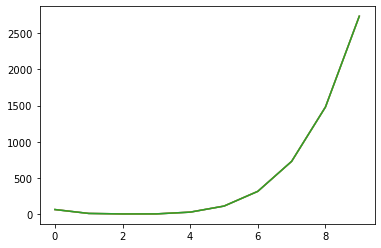

In [41]:
from matplotlib import pyplot as plt
plt.plot(yt.constant_cf)
plt.plot(y_np)
plt.plot(dCGP([x])[0].constant_cf)

## Problem P3: $\frac{e x^5 + x^3}{x + 1}$

In [ ]:
x = np.linspace(-0.9,1,10)
x = gdual(x)
yt = data_P3(x)

In [ ]:
# We run nexp experiments and accumulate statistic for the ERT
nexp = 100
offsprings = 4
max_gen=200
res = []
kernels = kernel_set(["sum", "mul", "diff", "div"])()
newtonParams = {
    'steps': 100,
}
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(1, 1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = np.random.randint(1233456))
    for j in range(dCGP.get_n(), dCGP.get_n() + dCGP.get_rows() * dCGP.get_cols()):
        for k in range(dCGP.get_arity()[0]):
            dCGP.set_weight(j, k, gdual([np.random.normal(0,1)]))
    g, best_chromosome, best_weights = run_experiment(dCGP, offsprings, max_gen, x, yt, newtonParams, screen_output=False)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (max_gen-1):
        print(i, "\t\t", res[i], "\t", dCGP.simplify(["x"],True))
res = np.array(res)

## Problem P4: $\sin(\pi x) + \frac 1x$

In [ ]:
x = np.linspace(-1,1,10)
x = gdual(x)
yt = data_P4(x)

In [ ]:
# We run nexp experiments and accumulate statistic for the ERT
nexp = 100
offsprings = 4
max_gen=200
res = []
kernels = kernel_set(["sum", "mul", "diff", "div", "sin"])()
newtonParams = {
    'steps': 100,
}
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(1, 1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = np.random.randint(1233456))
    for j in range(dCGP.get_n(), dCGP.get_n() + dCGP.get_rows() * dCGP.get_cols()):
        for k in range(dCGP.get_arity()[0]):
            dCGP.set_weight(j, k, gdual([np.random.normal(0,1)]))
    g, best_chromosome, best_weights = run_experiment(dCGP, offsprings, max_gen, x, yt, newtonParams, screen_output=False)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (max_gen-1):
        print(i, "\t\t", res[i], "\t", dCGP.simplify(["x"],True))
res = np.array(res)

##  Problem P5:  $ex^5 - \pi x^3 + x$

In [ ]:
x = np.linspace(1,3,10)
x = gdual(x)
yt = data_P5(x)

In [ ]:
# We run nexp experiments and accumulate statistic for the ERT
nexp = 100
offsprings = 4
max_gen=200
res = []
kernels = kernel_set(["sum", "mul", "diff", "div"])()
newtonParams = {
    'steps': 100,
}
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(1, 1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = np.random.randint(1233456))
    for j in range(dCGP.get_n(), dCGP.get_n() + dCGP.get_rows() * dCGP.get_cols()):
        for k in range(dCGP.get_arity()[0]):
            dCGP.set_weight(j, k, gdual([np.random.normal(0,1)]))
    g, best_chromosome, best_weights = run_experiment(dCGP, offsprings, max_gen, x, yt, newtonParams, screen_output=False)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (max_gen-1):
        print(i, "\t\t", res[i], "\t", dCGP.simplify(["x"],True))
res = np.array(res)

In [ ]:
mean_gen = sum(res) / sum(res<(max_gen-1)) * newtonParams['steps']
print("ERT Expected run time = avg. number of dCGP evaluations needed: ", mean_gen * offsprings)

##  Problem P6: $\frac{e x^2-1}{\pi (x + 2)}$

In [ ]:
x = np.linspace(-2.1,1,10)
x = gdual(x)
yt = data_P6(x)

In [ ]:
# We run nexp experiments and accumulate statistic for the ERT
nexp = 100
offsprings = 4
max_gen=200
res = []
kernels = kernel_set(["sum", "mul", "diff", "div"])()
newtonParams = {
    'steps': 100,
}
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(1, 1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = np.random.randint(1233456))
    for j in range(dCGP.get_n(), dCGP.get_n() + dCGP.get_rows() * dCGP.get_cols()):
        for k in range(dCGP.get_arity()[0]):
            dCGP.set_weight(j, k, gdual([np.random.normal(0,1)]))
    g, best_chromosome, best_weights = run_experiment(dCGP, offsprings, max_gen, x, yt, newtonParams, screen_output=False)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (max_gen-1):
        print(i, "\t\t", res[i], "\t", dCGP.simplify(["x"],True))
res = np.array(res)

##  Problem P7:  $\sin(e x) + \cos(\pi x)$

In [ ]:
x = np.linspace(-1,1,10)
x = gdual(x)
yt = data_P7(x)

In [ ]:
# We run nexp experiments and accumulate statistic for the ERT
nexp = 100
offsprings = 4
max_gen=200
res = []
kernels = kernel_set(["sum", "mul", "diff", "div", "sin", "cos"])()
newtonParams = {
    'steps': 100,
}
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(1, 1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = np.random.randint(1233456))
    for j in range(dCGP.get_n(), dCGP.get_n() + dCGP.get_rows() * dCGP.get_cols()):
        for k in range(dCGP.get_arity()[0]):
            dCGP.set_weight(j, k, gdual([np.random.normal(0,1)]))
    g, best_chromosome, best_weights = run_experiment(dCGP, offsprings, max_gen, x, yt, newtonParams, screen_output=False)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (max_gen-1):
        print(i, "\t\t", res[i], "\t", dCGP.simplify(["x"],True))
res = np.array(res)

In [53]:
import pickle as pk

In [57]:
f = open("buggy_dcgp_w.pk", "wb")


In [59]:
pk.dump(dCGP, f)

In [60]:
f.close

<function BufferedWriter.close>

In [61]:
ls

abalone_data_set.csv                       evo_in_parallel.ipynb
An_intro_to_dCGPANNs.ipynb                 finding_prime_integrals.ipynb
A_real-world_case2.ipynb                   learning_constants2.ipynb
A_real-world_case.ipynb                    learning_constants.ipynb
buggy_dcgp_w                               solving_odes.ipynb
buggy_dcgp_w.pk                            symbolic_regression_1.ipynb
custom_kernels.ipynb                       symbolic_regression_2.ipynb
dCGPANNs_for_classification.ipynb          symbolic_regression_3.ipynb
dCGPANNs_for_function_approximation.ipynb  weighted_symbolic_regression.ipynb
